In [1]:
import utils
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-paper')
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Computer Modern Roman'],
    'text.usetex': True
})

## Graph Topology and LLN
Simulates shock propagation in different graph topologies. Each node is shocked with a random shock (mu, sigma) in each round. The neighbouring nodes are updated following the shock, by using the minimum productivity value of all neighbours of the node. The code includes a simulation function to simulate the propagation pattern in various graph topologies with increasing node sizes and for a variable number of steps. The simulation is repeated n times, the volatility averaged and plotted

In [2]:
def run_simulation(create_network_func, steps, mean, sigma, n_runs, node_steps):
    volatilities = []

    for num_nodes in node_steps:   
        avg_volatility = simulate_for_node_count(create_network_func, num_nodes, steps, mean, sigma, n_runs)
        volatilities.append(avg_volatility)

    return volatilities


def simulate_for_node_count(create_network_func, num_nodes, steps, mean, sigma, n_runs):
    volatilities = []

    for _ in range(n_runs):
        G = create_network_func(num_nodes)
        _, total_productivity_list = sim_shocks(G, steps, mean, sigma)
        volatilities.append(calculate_volatility(total_productivity_list))

    return np.mean(volatilities)    # returns mean volatility over steps many iterations 

######################################################
# Variant 1: shocking only one node at a time
######################################################

# def sim_shocks(G, n_steps, mu, sigma, use_min=False):
#     total_productivity_list = []
# 
#     G = utils.assign_productivity(G)    # normalize all productivities = 1
#     total_productivity_list.append(utils.get_total_productivity(G))
# 
#     for step in range(n_steps):     # shocks in every round of the simulation
#         shock = np.random.normal(mu, sigma) # random shock: mu, sigma
#         selected_node = np.random.choice(list(G.nodes())) # random node of the graph chosen
#         G.nodes[selected_node]['productivity'] *= (1 + shock) # update productivity of node
#         total_productivity_list.append(utils.get_total_productivity(G)) # store total productivity
#         utils.propagation_step(G, use_min=use_min)  # productivity is the minimum of the incoming nodes
# 
#     log_vol = np.log(total_productivity_list)   # compute log volatility
# 
#     return log_vol, total_productivity_list


######################################################
# Variant 2: shocking all nodes at a time
######################################################
def sim_shocks(G, n_steps, mu, sigma, use_min=False):
    total_productivity_list = []

    G = utils.assign_productivity(G)
    total_productivity_list.append(utils.get_total_productivity(G))

    for step in range(n_steps):
        # Generate shocks for all nodes
        for node in G.nodes():
            shock = np.random.normal(mu, sigma)
            G.nodes[node]['productivity'] *= (1 + shock)

        total_productivity_list.append(utils.get_total_productivity(G))
        utils.propagation_step(G, use_min=use_min)

    log_vol = np.log(total_productivity_list)

    return log_vol, total_productivity_list


def calculate_volatility(total_productivity_list):
    return np.std(np.log(total_productivity_list))


def plot_results(node_steps, results, sigma, steps, n_runs, mean):
    plt.rcParams.update({
        'font.family': 'serif',
        'font.serif': ['Computer Modern Roman'],
        'text.usetex': True,
        'font.size': 12,
        'axes.grid': True,
        'grid.alpha': 0.3,
        'grid.color': 'gray',
        'axes.facecolor': 'white'
    })
   
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111)

    colors = {
       'Circle Network': '#4a90e2',
       'Horizontal Network': '#50c878',
       'Vertical Network': '#e35f5f',
       'Star Network': '#9b59b6',
       'Complete Network': '#f39c12'
    }

    for network_name, avg_volatilities in results.items():
        ax.plot(node_steps, avg_volatilities, marker='o', 
                label=network_name, color=colors[network_name])

    sqrt_n_baseline = np.log(sigma / np.sqrt(node_steps))
    ax.plot(node_steps, sqrt_n_baseline, linestyle='--', 
            color='#95a5a6', label=r'$\sigma/\sqrt{n}$ Baseline')

    fig.suptitle(r'Average (log) Volatility vs. Number of Nodes', y=0.95, fontsize=24)  # Increased fontsize
    plt.title(r'Parameters: propagation steps={}, simulation runs={}, $\mathcal{{N}}({}, {})$'.format(
        steps, n_runs, mean, sigma), fontsize=18, pad=5)  # Increased fontsize

    ax.set_xlabel('Number of Nodes', fontsize=16)  # Increased fontsize
    ax.set_ylabel('Mean (log) Volatility', fontsize=16)  # Increased fontsize
    ax.legend(fancybox=True, framealpha=1, fontsize=16)  # Increased fontsize for legend

    # Increase tick label sizes
    ax.tick_params(axis='both', which='major', labelsize=14)  # Increased tick label size
    ax.tick_params(axis='both', which='minor', labelsize=14)  # Optional: increase minor tick label size

    ax.grid(True, which='major', linestyle='--', alpha=0.2)
    ax.set_axisbelow(True)
    plt.show()

## Simulation Loop

In [3]:
def main():
    # Simulation parameters
    steps = 10
    mean = 0
    sigma = 0.01
    n_runs = 100
    node_steps = np.unique(np.logspace(0, np.log10(200), num=15, dtype=int))  # Exponentially increasing node count

    # Define the network layout functions
    network_funcs = {
        "Horizontal Network": utils.horizontal_toy_network,
        "Circle Network": utils.circle_toy_network,
        "Complete Network": utils.full_toy_network,
        "Vertical Network": utils.vertical_toy_network,
        "Star Network": utils.star_toy_network
    }

    # Store the results for each network layout
    results = {}

    # Run simulations for each network type
    for network_name, create_network_func in network_funcs.items():
        avg_volatilities = run_simulation(create_network_func, steps, mean, sigma, n_runs, node_steps)
        results[network_name] = np.log(avg_volatilities)

    # Plot the results
    plot_results(node_steps, results, sigma, steps, n_runs, mean)
    
    plt.savefig('plots/volatility.png')

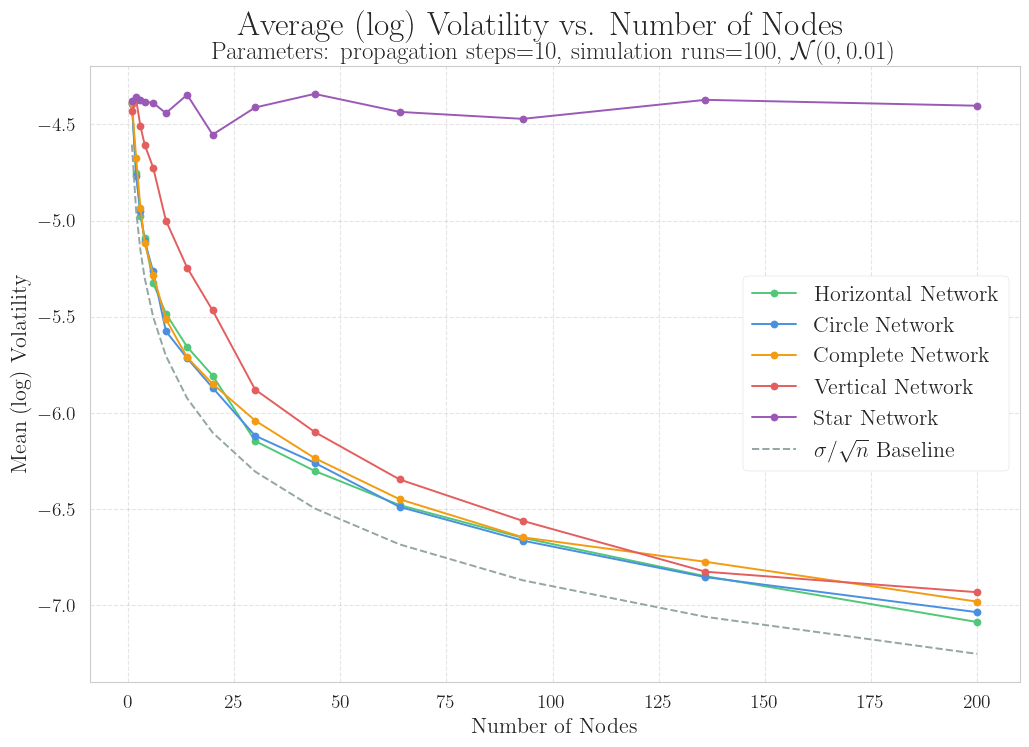

<Figure size 640x440 with 0 Axes>

In [4]:
main()

## Toy Networks illustrations

In [6]:
def create_horizontal_network(n):
    G = nx.DiGraph()
    G.add_nodes_from(range(n))
    return G

def create_circle_network(n):
    G = nx.DiGraph()
    G.add_nodes_from(range(n))
    for i in range(n):
        G.add_edge(i, (i + 1) % n)
    return G

def create_complete_network(n):
    G = nx.DiGraph()
    G.add_nodes_from(range(n))
    for i in range(n):
        for j in range(n):
            if i != j:
                G.add_edge(i, j)
    return G

def create_vertical_network(n):
    G = nx.DiGraph()
    G.add_nodes_from(range(n))
    for i in range(n-1):
        G.add_edge(i, i+1)
    return G

def create_star_network(n):
    G = nx.DiGraph()
    G.add_nodes_from(range(n))
    for i in range(1, n):
        G.add_edge(0, i)
    return G

def horizontal_layout(G):
    pos = {}
    for i, node in enumerate(G.nodes()):
        pos[node] = (i, 0)
    return pos

def vertical_layout(G):
    pos = {}
    for i, node in enumerate(G.nodes()):
        pos[node] = (0, i)
    return pos

def star_layout(G):
    pos = nx.spring_layout(G)
    center = pos[0]
    angle = 0
    for i, node in enumerate(G.nodes()):
        if i == 0:
            continue
        pos[node] = (center[0] + np.cos(angle), center[1] + np.sin(angle))
        angle += 2 * np.pi / (len(G.nodes()) - 1)
    return pos

def plot_layouts(n=6):
    plt.rcParams.update({
        'font.family': 'serif',
        'font.serif': ['Computer Modern Roman'],
        'text.usetex': True
    })
   
    fig, axes = plt.subplots(1, 5, figsize=(25, 5))
   
    colors = {
        '(a) Horizontal Network': '#50c878',  
        '(b) Circle Network': '#4a90e2',      
        '(c) Complete Network': '#f39c12',    
        '(d) Vertical Network': '#e35f5f',    
        '(e) Star Network': '#9b59b6'         
    }

    networks = [
        ("(a) Horizontal Network", create_horizontal_network, horizontal_layout),
        ("(b) Circle Network", create_circle_network, nx.circular_layout),
        ("(c) Complete Network", create_complete_network, nx.circular_layout),
        ("(d) Vertical Network", create_vertical_network, vertical_layout),
        ("(e) Star Network", create_star_network, star_layout)
    ]

    for ax, (name, create_func, layout_func) in zip(axes, networks):
        G = create_func(n)
        pos = layout_func(G)
        ax.set_title(name, fontsize=40, pad=5)  # Increased fontsize for titles
        nx.draw(G, pos, ax=ax, 
                node_color=colors[name],
                node_size=500,
                with_labels=False, 
                arrowsize=20,
                edge_color='#666666',
                edgecolors=colors[name],
                linewidths=5)

    plt.tight_layout()
    plt.show()
    
    plt.savefig('plots/toy_networks.png')

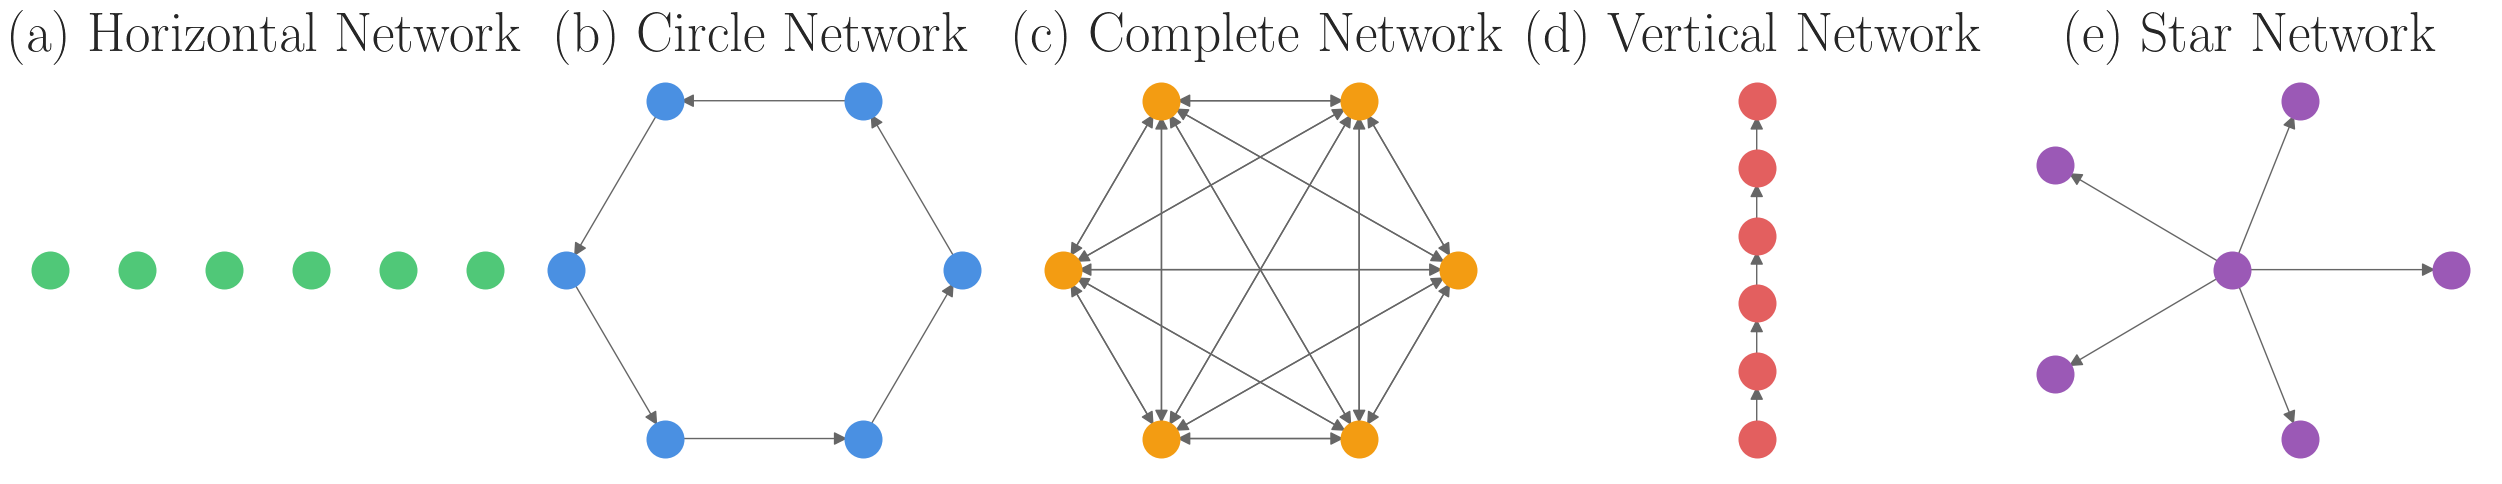

<Figure size 640x440 with 0 Axes>

In [7]:
plot_layouts(6)

## Fragility

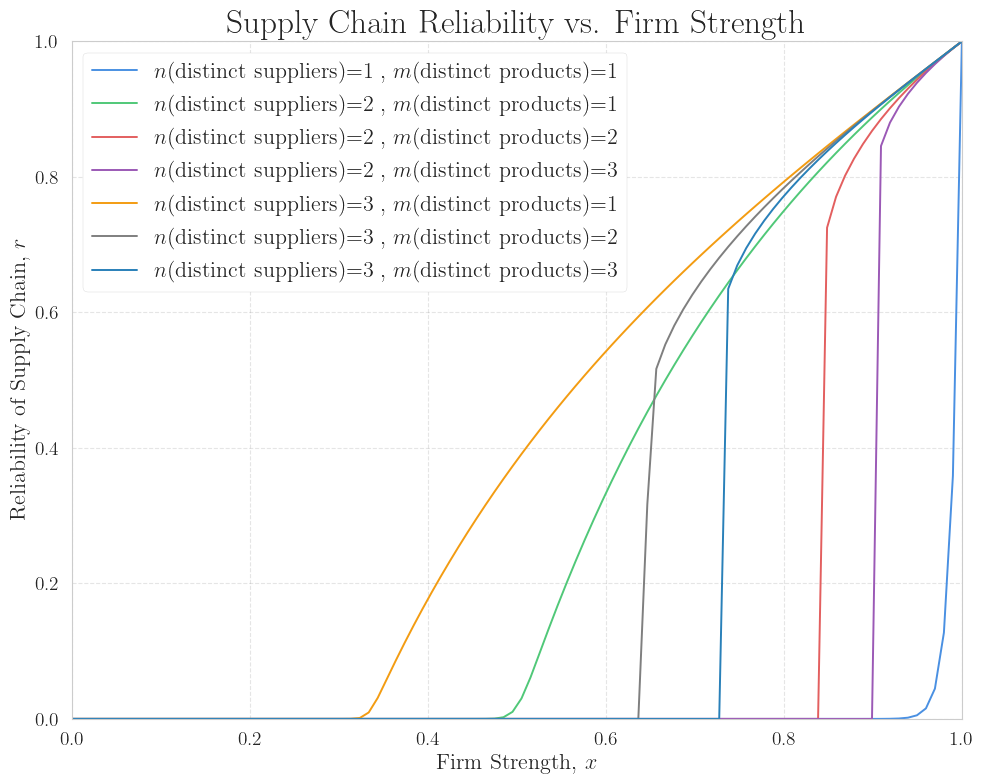

<Figure size 640x440 with 0 Axes>

In [8]:
# Function to compute the reliability of a node given the reliability of its suppliers
def R_x(r, x, n, m):
    return x * (1 - (1 - r)**n)**m

# Function to compute the fixed point reliability
def compute_fixed_point(x, n, m, max_iterations=100, tolerance=1e-6):
    r = x  # Start with the reliability of level-0 nodes
    for _ in range(max_iterations):
        new_r = R_x(r, x, n, m)
        if abs(new_r - r) < tolerance:  # Check for convergence
            break
        r = new_r
    return r

def plot_reliability_vs_strength(x_values, combinations):
    plt.rcParams.update({
        'font.family': 'serif',
        'font.serif': ['Computer Modern Roman'],
        'text.usetex': True,
        'font.size': 12,
        'axes.grid': True,
        'grid.alpha': 0.3,
        'grid.color': 'gray',
        'axes.facecolor': 'white'
    })

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111)

    # Define a color palette for the plots
    colors = {
        (1, 1): '#4a90e2',  # Circle Network
        (2, 1): '#50c878',  # Horizontal Network
        (2, 2): '#e35f5f',  # Vertical Network
        (2, 3): '#9b59b6',  # Star Network
        (3, 1): '#f39c12',  # Complete Network
        (3, 2): '#7f7f7f',  # Additional color
        (3, 3): '#2980b9'   # Additional color
    }

    for (n, m) in combinations:
        reliabilities = [compute_fixed_point(x, n, m) for x in x_values]

        # Plot the results for the current combination of n and m
        ax.plot(x_values, reliabilities, label=f'$n$(distinct suppliers)={n} , $m$(distinct products)={m} ', color=colors[(n, m)])

    # Customize the plot
    ax.set_xlabel('Firm Strength, $x$', fontsize=16)  # Increased fontsize
    ax.set_ylabel('Reliability of Supply Chain, $r$', fontsize=16)  # Increased fontsize
    ax.set_title('Supply Chain Reliability vs. Firm Strength', fontsize=24)  # Increased fontsize
    ax.legend(loc='upper left', fancybox=True, framealpha=1, fontsize=16)  # Increased fontsize for legend
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.tick_params(axis='both', which='major', labelsize=14)  # Increased tick label size
    ax.tick_params(axis='both', which='minor', labelsize=14)  # Optional: increase minor tick label size
    ax.axhline(0, color='black', lw=0.5, ls='--')
    ax.axvline(0, color='black', lw=0.5, ls='--')
    ax.axvline(1, color='black', lw=0.5, ls='--')  # Add right vertical line
    ax.grid(True, which='major', linestyle='--', alpha=0.2)
    ax.set_axisbelow(True)

    # Add minor ticks
    ax.minorticks_on()

    # Adjust layout
    plt.tight_layout()

    plt.show()
    
    plt.savefig('plots/reliability.png')

# Parameters for the simulation
x_values = np.linspace(0, 1, 100)  # Firm strength values
combinations = [(1, 1), (2, 1), (2, 2), (2, 3), (3, 1), (3, 2), (3, 3)]  # Various combinations of (n, m)

# Generate the plot
plot_reliability_vs_strength(x_values, combinations)